In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

### Load the player data

In [2]:
phs_2021_1 = pd.read_csv("data/phs_2021_1.csv")
phs_2020_1 = pd.read_csv("data/phs_2020_1.csv")
phs_2020_2 = pd.read_csv("data/phs_2020_2.csv")
phs_df = pd.concat([phs_2021_1, phs_2020_1, phs_2020_2])
phs_df.head()

,start_time,esports_match_id,tournament_title,map_type,map_name,player_name,team_name,stat_name,hero_name,stat_amount
0,2021-04-16 19:08:52,37234,OWL 2021,CONTROL,Busan,Doha,Dallas Fuel,All Damage Done,All Heroes,13900.680095
1,2021-04-16 19:08:52,37234,OWL 2021,CONTROL,Busan,Doha,Dallas Fuel,Assists,All Heroes,8.000000
2,2021-04-16 19:08:52,37234,OWL 2021,CONTROL,Busan,Doha,Dallas Fuel,Average Time Alive,All Heroes,56.481102
3,2021-04-16 19:08:52,37234,OWL 2021,CONTROL,Busan,Doha,Dallas Fuel,Barrier Damage Done,All Heroes,1495.492155
4,2021-04-16 19:08:52,37234,OWL 2021,CONTROL,Busan,Doha,Dallas Fuel,Damage - Quick Melee,All Heroes,60.000000


### Data cleaning


In [3]:
# remove data with all heroes
phs_df = phs_df[phs_df["hero_name"]!="All Heroes"]
# remove data of three solo maps
phs_df = phs_df[
    (phs_df["map_name"]!="Castillo") &
    (phs_df["map_name"]!="Ecopoint: Antarctica") &
    (phs_df["map_name"]!="Necropolis")
]
# create hero and status amount dataframe
hero_player_stat_data = phs_df.groupby(["hero_name", "stat_name", "player_name"])["stat_amount"].agg(np.mean).reset_index()
hero_player_stat_data

,hero_name,stat_name,player_name,stat_amount
0,Ana,All Damage Done,AimGod,3556.073910
1,Ana,All Damage Done,Alarm,4461.771940
2,Ana,All Damage Done,Anamo,839.628085
3,Ana,All Damage Done,Architect,7795.636898
4,Ana,All Damage Done,Aztac,7922.284263
...,...,...,...,...
91935,Zenyatta,Weapon Accuracy,moth,0.188199
91936,Zenyatta,Weapon Accuracy,ryujehong,0.302635
91937,Zenyatta,Weapon Accuracy,shu,0.252649
91938,Zenyatta,Weapon Accuracy,skewed,0.196812


In [4]:
stats = list(hero_player_stat_data["stat_name"].unique())
stats

['All Damage Done',
 'Assists',
 'Average Time Alive',
 'Barrier Damage Done',
 'Biotic Grenade Kills',
 'Damage - Biotic Grenade',
 'Damage - Quick Melee',
 'Damage - Weapon',
 'Damage - Weapon Scoped',
 'Damage Taken',
 'Deaths',
 'Defensive Assists',
 'Eliminations',
 'Enemies Slept',
 'Environmental Deaths',
 'Environmental Kills',
 'Final Blows',
 'Healing - Biotic Grenade',
 'Healing - Weapon',
 'Healing - Weapon Scoped',
 'Healing Amplified',
 'Healing Done',
 'Healing Received',
 'Hero Damage Done',
 'Melee Final Blows',
 'Multikills',
 'Nano Boost Assists',
 'Nano Boost Efficiency',
 'Nano Boosts Applied',
 'Objective Kills',
 'Objective Time',
 'Offensive Assists',
 'Quick Melee Accuracy',
 'Quick Melee Hits',
 'Quick Melee Ticks',
 'Scoped Accuracy',
 'Scoped Hits',
 'Scoped Shots',
 'Self Healing',
 'Self Healing Percent of Damage Taken',
 'Shots Fired',
 'Shots Hit',
 'Shots Missed',
 'Sleep Dart Hits',
 'Sleep Dart Shots',
 'Sleep Dart Success Rate',
 'Solo Kills',
 'Time

### K-means clustering for heroes

In [5]:
# get the shared status
hero_stats = hero_player_stat_data.groupby("hero_name")["stat_name"].agg(lambda x: set(x)).reset_index()
for stat in stats:
    for i in range(len(hero_stats)):
        if ((stat not in hero_stats.loc[i, "stat_name"]) & (stat in stats)):
            stats[stats.index(stat)] = None
shared_hero_stats = list(filter(lambda x: x is not None, stats))
# filter out the shared status from the hero_stat_data dataframe
hero_player_shared_stat_data = hero_player_stat_data[hero_player_stat_data["stat_name"].isin(shared_hero_stats)]
hero_player_shared_stat_data

,hero_name,stat_name,player_name,stat_amount
0,Ana,All Damage Done,AimGod,3556.073910
1,Ana,All Damage Done,Alarm,4461.771940
2,Ana,All Damage Done,Anamo,839.628085
3,Ana,All Damage Done,Architect,7795.636898
4,Ana,All Damage Done,Aztac,7922.284263
...,...,...,...,...
91876,Zenyatta,Ultimates Used,moth,2.416667
91877,Zenyatta,Ultimates Used,ryujehong,3.000000
91878,Zenyatta,Ultimates Used,shu,2.705882
91879,Zenyatta,Ultimates Used,skewed,2.214286


In [6]:
hero_list = list(hero_player_shared_stat_data["hero_name"].unique())
hero_stats_array = np.zeros((len(hero_list), len(shared_hero_stats)))
for hero in hero_list:
    for stat in shared_hero_stats:
        hero_index = hero_list.index(hero)
        stat_index = shared_hero_stats.index(stat)
        hero_stats_array[hero_index][stat_index] = hero_player_shared_stat_data[
            (hero_player_shared_stat_data["hero_name"]==hero) &
            (hero_player_shared_stat_data["stat_name"]==stat)
        ]["stat_amount"].agg(np.mean)
hero_stats_standardized_array = StandardScaler().fit_transform(hero_stats_array)

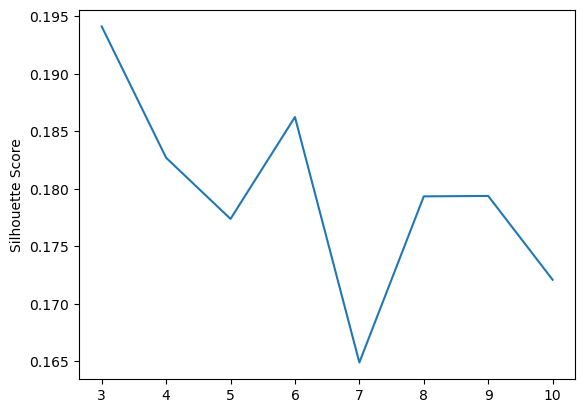

In [7]:
sil_hero = []
kmax = 10
for k in range(3, kmax+1):
    kmeans = KMeans(n_clusters = k).fit(hero_stats_standardized_array)
    labels = kmeans.labels_
    sil_hero.append(silhouette_score(hero_stats_standardized_array, labels, metric = 'euclidean'))
#plot the silhouette score
plt.plot(range(3, kmax+1), sil_hero)
plt.ylabel('Silhouette Score')
plt.show()

### Agglomerative clustering for heroes

In [8]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_, counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [9]:
agglo = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage="complete").fit(hero_stats_standardized_array)

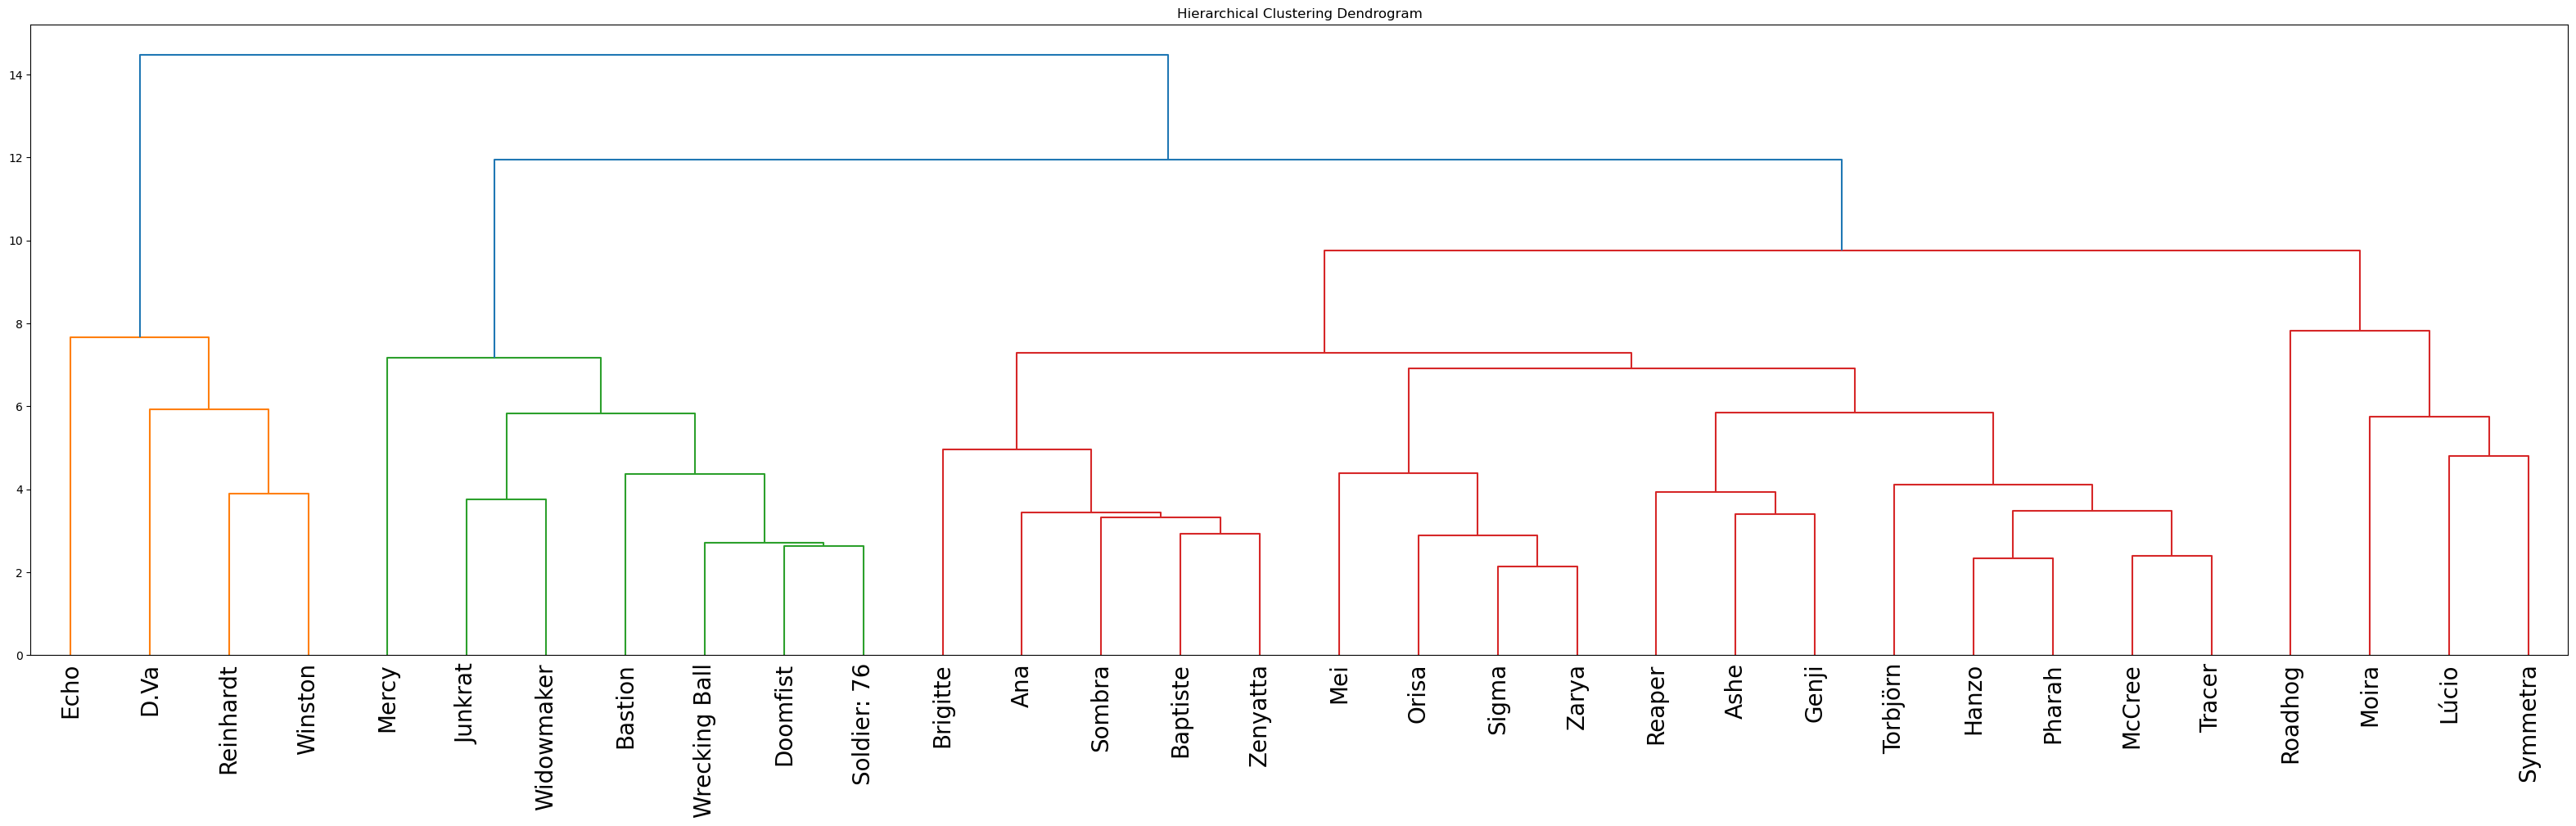

In [10]:
fig, ax = plt.subplots()
fig.set_size_inches(40, 10)
plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(agglo, labels=hero_list)
# setting the axis labels to increase font size
ax.tick_params(axis='x', which='major', labelsize=20)
plt.xticks(rotation=90)
plt.show()

# Basic stats that shown in game dashboard

In [11]:
basic_stats = ["All Damage Done", "Damage Blocked", "Healing Done"]
hero_basic_stats_array = np.zeros((len(hero_list), len(basic_stats)))
for hero in hero_list:
    for stat in basic_stats:
        hero_index = hero_list.index(hero)
        stat_index = basic_stats.index(stat)
        hero_basic_stats_array[hero_index][stat_index] = hero_player_stat_data[
            (hero_player_stat_data["hero_name"]==hero) &
            (hero_player_stat_data["stat_name"]==stat)
        ]["stat_amount"].agg(np.mean)
hero_basic_stats_array = np.nan_to_num(hero_basic_stats_array)


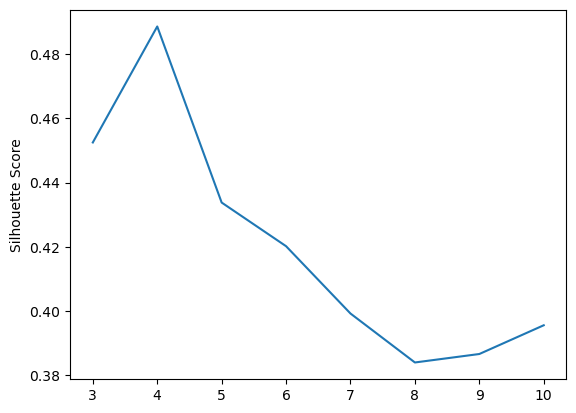

In [12]:
sil_hero = []
kmax = 10
for k in range(3, kmax+1):
    kmeans = KMeans(n_clusters = k).fit(hero_basic_stats_array)
    labels = kmeans.labels_
    sil_hero.append(silhouette_score(hero_basic_stats_array, labels, metric = 'euclidean'))
#plot the silhouette score
plt.plot(range(3, kmax+1), sil_hero)
plt.ylabel('Silhouette Score')
plt.show()

In [13]:
agglo2 = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage="complete").fit(hero_basic_stats_array)

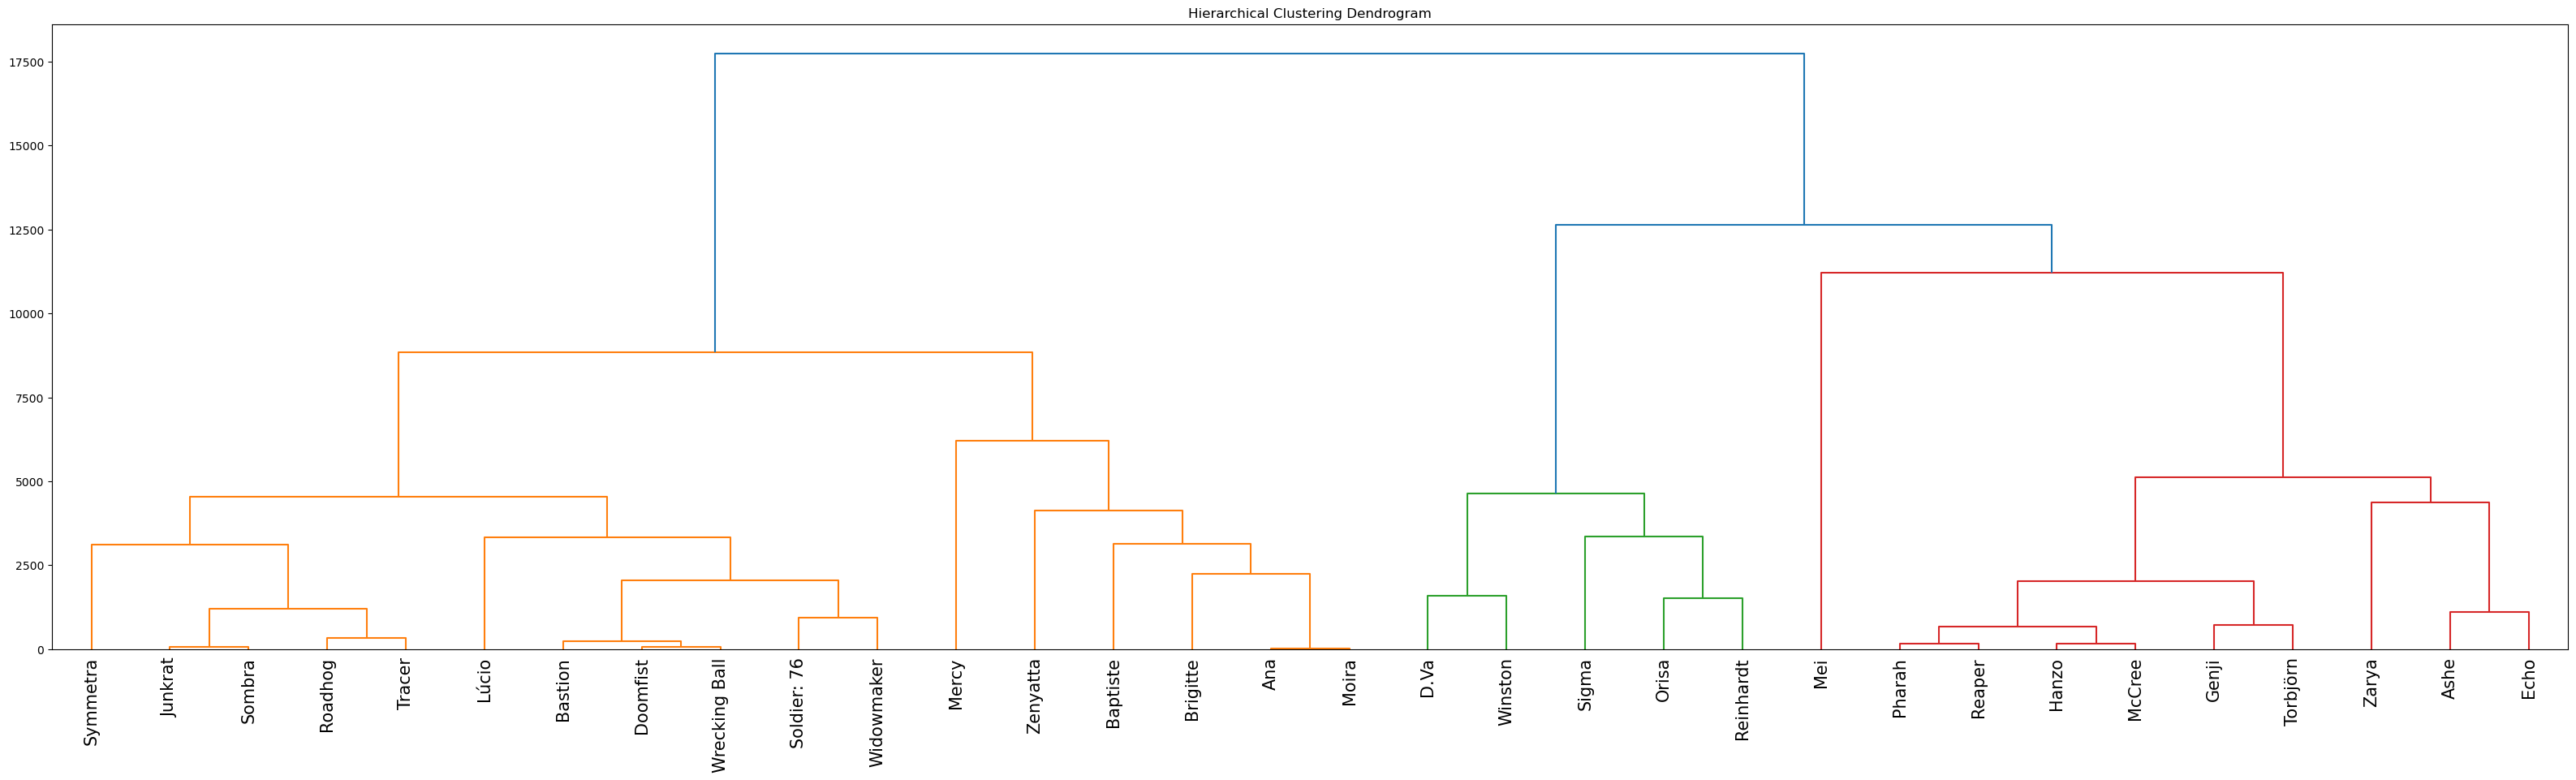

In [14]:
fig, ax = plt.subplots()
fig.set_size_inches(40, 10)
plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(agglo2, labels=hero_list)
# setting the axis labels to increase font size
ax.tick_params(axis='x', which='major', labelsize=15)
plt.xticks(rotation=90)
plt.show()

### Dimension reduction before clustering

In [15]:
pca = PCA()
pca.fit(hero_stats_standardized_array)
pca.explained_variance_ratio_.cumsum()

array([0.47899525, 0.61710751, 0.73124186, 0.80170184, 0.84475998,
       0.87914053, 0.90222161, 0.92243712, 0.94059438, 0.95415471,
       0.96703796, 0.97661145, 0.98458635, 0.99095434, 0.99383034,
       0.99601375, 0.99769055, 0.99865   , 0.99937186, 0.99981171,
       0.99992565, 0.9999678 , 0.99999216, 1.        ])

Text(0, 0.5, 'Cumulative Explained Variance')

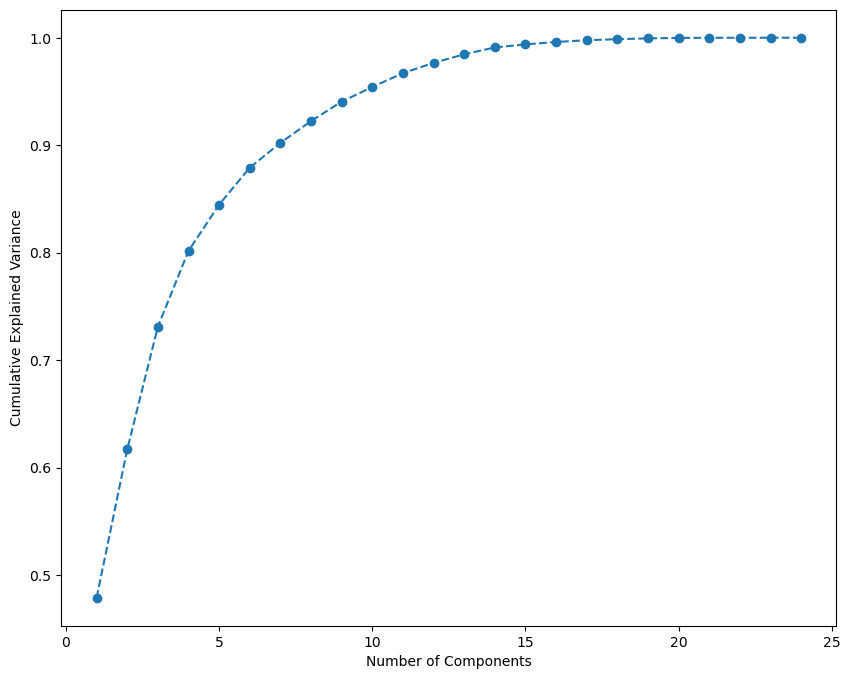

In [16]:
plt.figure(figsize=(10,8))
plt.plot(range(1,25), pca.explained_variance_ratio_.cumsum(), marker="o",linestyle="--")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")

In [20]:
pca = PCA(n_components=5)
pca.fit(hero_stats_standardized_array)
hero_stats_stardardized_pca_array = pca.transform(hero_stats_standardized_array)

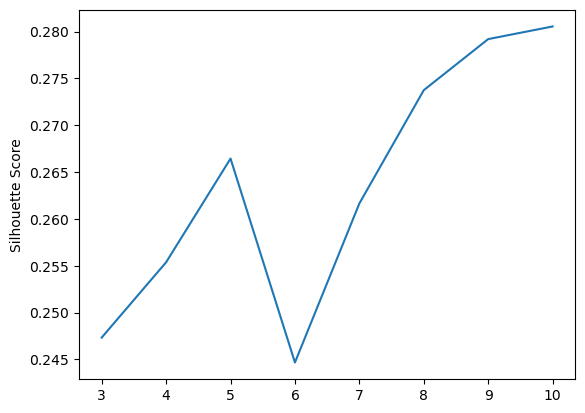

In [21]:
sil_hero_pca = []
kmax = 10
for k in range(3, kmax+1):
    kmeans = KMeans(n_clusters = k).fit(hero_stats_stardardized_pca_array)
    labels = kmeans.labels_
    sil_hero_pca.append(silhouette_score(hero_stats_stardardized_pca_array, labels, metric = 'euclidean'))
#plot the silhouette score
plt.plot(range(3, kmax+1), sil_hero_pca)
plt.ylabel('Silhouette Score')
plt.show()

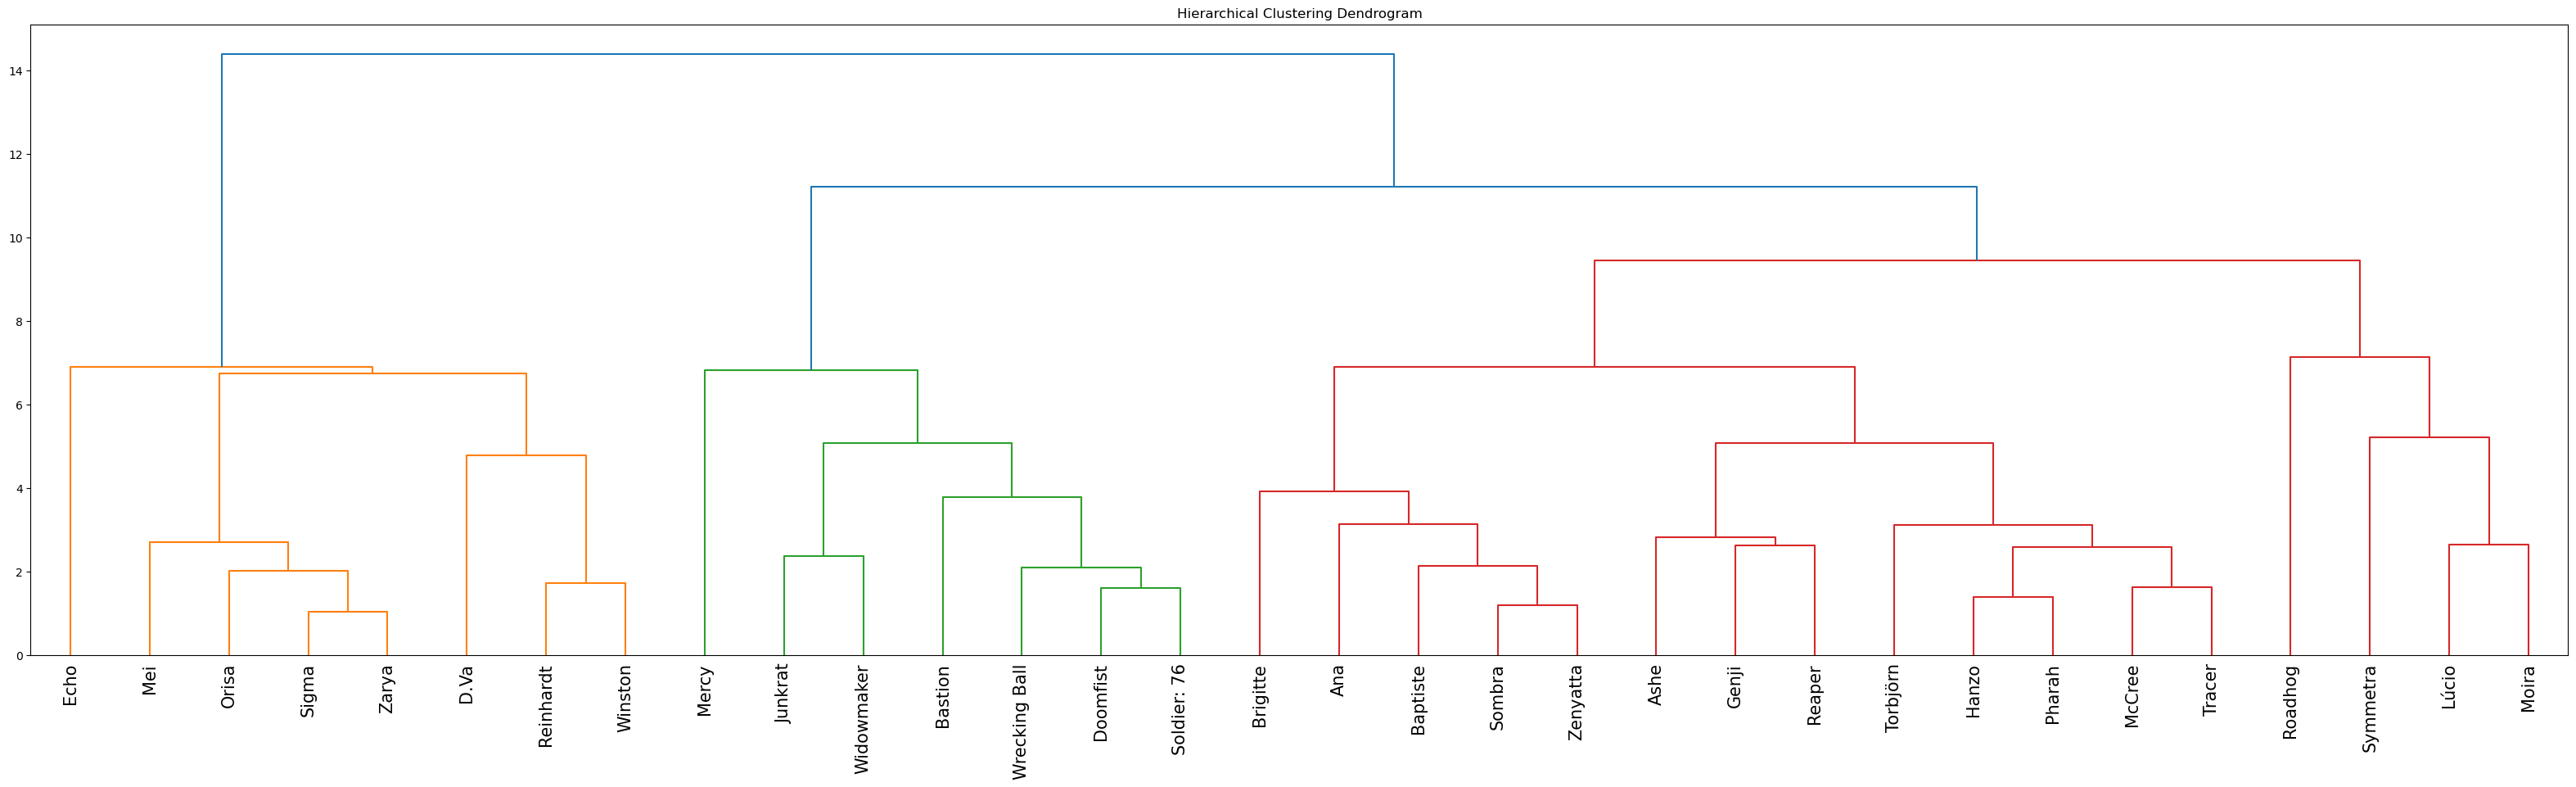

In [22]:
agglo3 = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage="complete").fit(hero_stats_stardardized_pca_array)
fig, ax = plt.subplots()
fig.set_size_inches(40, 10)
plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(agglo3, labels=hero_list)
# setting the axis labels to increase font size
ax.tick_params(axis='x', which='major', labelsize=15)
plt.xticks(rotation=90)
plt.show()